In [1]:
import re
import os
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from gensim.models import word2vec
import gensim
import logging

from keras.utils.vis_utils import plot_model

from sklearn.preprocessing import MinMaxScaler
from DataProcess import DataProcess

from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding

from keras.preprocessing.text import one_hot
from DP_LSTM import *

from sklearn.model_selection import train_test_split

from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.preprocessing import sequence
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D,Conv2D,Conv1D,GlobalMaxPooling1D,Input
from keras.layers.core import Dense, Dropout, Activation, Flatten

Using TensorFlow backend.


In [2]:
# 新闻处理
data_processor = DataProcess(
                             dow_jons_path=r'/home/wells/SIOA/DowJonesPredict/SourceData/DowJones.csv',
                             news_path=r'/home/wells/SIOA/DowJonesPredict/SourceData/News.csv',
                             save_model_file=r'/home/wells/SIOA/DowJonesPredict/SourceData//',
                            # padding_size = 1500,
                            # vector_size = 64
                            )
dow_jons_pd = data_processor.run_engine()

dow_jons_pd = dow_jons_pd.sort_index(ascending=False)
dow_jons_pd = dow_jons_pd.reset_index(drop=True)

In [3]:
dow_jons_pd.head()

,Date,Open,price_flag,today_news
0,2008-08-11,11729.669922,0,wont america nato help us wont help us help ir...
1,2008-08-12,11781.700195,0,remember adorable 9 year old sang opening cere...
2,2008-08-13,11632.809570,1,united states refuses israel weapons attack ir...
3,2008-08-14,11532.070312,1,experts admit legalise drugs war south osetia ...
4,2008-08-15,11611.209961,0,mom missing gay man bad hes 21 year old cheerl...


In [4]:
# 统计news 中有多少不相同的词
def count_diff_words(data_pd):
    res_num = 0
    word_set = set()
    for sentence in data_pd.today_news:
        words = sentence.split()
        for word in words:
            if word not in word_set:
                res_num += 1
                word_set.add(word)
    return res_num


# 处理新闻DataFrame,转成index arrary
def propose_news_array(dow_jons_pd,max_length):
    vocab_size = count_diff_words(dow_jons_pd)
    encoded_docs = [one_hot(d, vocab_size) for d in dow_jons_pd.today_news]
    padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
    return padded_docs

In [15]:
# 模型融合
def build_fusion_model(params):
    from keras.optimizers import RMSprop,Adam
    from keras.models import Sequential
    from keras.layers import Dense,concatenate,Reshape,Convolution2D
    from keras.layers.recurrent import LSTM
    from keras.layers.recurrent import GRU
    from keras.layers.core import Dropout
    from keras.backend import reshape
    from keras.utils import plot_model
    
    # cnn模型部分
    cnn_input = Input(shape=(params['cnn_param']['embedding']['imput_length'],))
    cnn_embedding = Embedding(params['cnn_param']['embedding']['imput_dim'], 
                        params['cnn_param']['embedding']['output_dim'], 
                        input_length=(params['cnn_param']['embedding']['imput_length'],))(cnn_input)
    
    reshape_cnn = Reshape((params['cnn_param']['embedding']['imput_length'],params['cnn_param']['embedding']['output_dim'],1))(cnn_embedding)
    conv_1 = Convolution2D(
#                            batch_input_shape=(None, params['cnn_param']['embedding']['imput_length'],
#                                               params['cnn_param']['embedding']['output_dim'],1),
                           filters=params['cnn_param']['n_filter'],
                           kernel_size=params['cnn_param']['kernel_size'],
                           strides=1,
                           padding='same',
                           data_format='channels_last',
                           activation='relu'
                          )(reshape_cnn)

    max_pool_1 = MaxPooling2D(pool_size=(params['cnn_param']['n_pool'], params['cnn_param']['n_pool']))(conv_1)
    conv_2 = Convolution2D(
#                            batch_input_shape=(None, params['cnn_param']['embedding']['imput_length'],
#                                               params['cnn_param']['embedding']['output_dim'],1),
                           filters=params['cnn_param']['n_filter'],
                           kernel_size=params['cnn_param']['kernel_size'],
                           strides=1,
                           padding='same',
                           data_format='channels_last',
                           activation='relu'
                          )(max_pool_1)
    max_pool_2 = MaxPooling2D(pool_size=(params['cnn_param']['n_pool'], params['cnn_param']['n_pool']))(conv_2)
    #cnn_drop = Dropout(rate=0.25)(max_pool_1)
    flat_cnn = Flatten()(max_pool_2)
    cnn_dense = Dense(params['cnn_param']['dense_dim'],activation='relu',use_bias=True)(flat_cnn)
    reshape_cnn_dense = Reshape((1,params['cnn_param']['dense_dim']))(cnn_dense)
    #predictions_layer = Dense(1,activation='sigmoid')(cnn_dense)
    
    # lstm模型部分
    lstm_imput = Input(shape=(1,params['lstm_param']['TimeLag']))  # input_shape=(1,params['lstm_param']['TimeLag']),
    lstm_layer_1 = LSTM(params['lstm_param']['nb_hidden_cell'][0],use_bias=True,activation='relu',name='layer_0',return_sequences=True)(lstm_imput)
    lstm_layer_2 = LSTM(params['lstm_param']['nb_hidden_cell'][1],use_bias=True,activation='tanh',name='layer_1',return_sequences=True)(lstm_layer_1)
    lstm_layer_3 = LSTM(params['lstm_param']['nb_hidden_cell'][2],use_bias=True,activation='tanh',name='layer_2',return_sequences=True)(lstm_layer_2)
    #lstm_layer_4 = LSTM(params['lstm_param']['nb_hidden_cell'][3],use_bias=True,activation='tanh',name='layer_3',return_sequences=True)(lstm_layer_3)
    #lstm_layer_5 = LSTM(params['lstm_param']['nb_hidden_cell'][4],use_bias=True,activation='tanh',name='layer_4',return_sequences=True)(lstm_layer_4)
    lstm_dense = Dense(params['lstm_param']['dense_dim'],use_bias=True,activation='linear',name='last')(lstm_layer_3)
#     lstm_predict_layer = Dense(1,activation='linear')(lstm_dense)

    fusion_layer = concatenate([reshape_cnn_dense, lstm_dense])
    fusion_drop = Dropout(rate=0.25)(fusion_layer)
    dense_layer = Dense(8,activation='tanh',use_bias=True)(fusion_drop)
  #  print(fusion_layer.shape)
    
    predict_payer = Dense(1,activation='linear',use_bias=True)(dense_layer)
    
    fusion_model = Model(inputs=[cnn_input, lstm_imput], outputs=predict_payer)
    adam_optimizer = Adam(lr=params['lr'])
    fusion_model.compile(optimizer=adam_optimizer,loss='mse',metrics=['mae','mape'])
    print(fusion_model.summary())
    
    plot_model(fusion_model, to_file='/home/wells/SIOA/DowJonesPredict/SourceCode/PicSave/ModelImage.png',show_shapes=True)
    return fusion_model


In [16]:
'''数据处理模块'''
#对实验数据进行归一化处理
def Raw_Data_Normalized(Raw_df): # 标准化数据
    Raw_pd = Raw_df.copy()
    MMScaler = MinMaxScaler(feature_range=(0.1,1))
    MMScaled_Data = MMScaler.fit_transform(np.reshape(Raw_pd['Open'].get_values(),(Raw_pd.Open.shape[0],1)))
    Raw_pd['OpenScaled'] = MMScaled_Data
    return Raw_pd,MMScaler

def GetTimeSeriesData(Normalized_pd, TimeLag): #根据时滞创建时间序列数据
    # 输入 标准化后的完整数据、时滞TimeLag
    # 输出 时间序列数据 np.array
    sequence_length = TimeLag + 1
    result = []
    for index in range(len(Normalized_pd) - sequence_length+1):
        result.append(Normalized_pd.OpenScaled[index: index + sequence_length])
    result = np.array(result)
    return result

In [17]:
# 尝试训练函数式fusion模型
def train_fusion_model(data_pd,padded_news_index,params,saveFile=r'/home/wells/SIOA/DowJonesPredict/SourceCode/ModelFile'):
    checkpointer = ModelCheckpoint(filepath=saveFile + '/checkpoint.hdf5',
                                   monitor = 'val_mean_absolute_percentage_error',save_best_only=True)
    result_pd = pd.DataFrame(columns=['TimeLags','RMSE','MAE','MAPE','RMSE_BP','MAE_BP','MAPE_BP'])
    line_pd = pd.DataFrame(columns=['TimeLags','RMSE','MAE','MAPE','RMSE_BP','MAE_BP','MAPE_BP'])
    
    normalized_pd, MMScaler = Raw_Data_Normalized(dow_jons_pd)
    #print(normalized_pd)
    TimeSeries = GetTimeSeriesData(normalized_pd, params['lstm_param']['TimeLag'])
    print(TimeSeries.shape)
    fusion_model = build_fusion_model(params)
    
    TrainSeries = TimeSeries[:round(params['lstm_param']['TrainTestSplit']*TimeSeries.shape[0]),:]
    print(r'训练数据:',TrainSeries.shape)
    TestSeries = TimeSeries[round(params['lstm_param']['TrainTestSplit']*TimeSeries.shape[0]):,:]
    print(r'测试数据:',TestSeries.shape)
    TrainSeries_X = TrainSeries[:,:-1]
    TrainSeries_Y = TrainSeries[:,-1]
    TestSeries_X = TestSeries[:,:-1]
    TestSeries_Y = TestSeries[:,-1]
    
    # 张量化
    Train_X = np.reshape(TrainSeries_X, (TrainSeries_X.shape[0], 1,TrainSeries_X.shape[1]))
    Train_Y = np.reshape(TrainSeries_Y, (TrainSeries_Y.shape[0], 1,1))
    Test_X = np.reshape(TestSeries_X, (TestSeries_X.shape[0], 1,TestSeries_X.shape[1]))
    Test_Y = np.reshape(TestSeries_Y, (TestSeries_Y.shape[0], 1,1))
    
    padded_news_index = padded_news_index[params['lstm_param']['TimeLag']-1:len(padded_news_index)-1]
    train_news = padded_news_index[:round(params['lstm_param']['TrainTestSplit']*TimeSeries.shape[0])]
    test_news = padded_news_index[round(params['lstm_param']['TrainTestSplit']*TimeSeries.shape[0]):]
    checkpointer = ModelCheckpoint(filepath=saveFile + '/checkpoint.hdf5',
                                   monitor = 'val_mean_absolute_percentage_error',save_best_only=True)
    
    print(Train_X.shape)
    print(train_news.shape)
    
    print(Test_X.shape)
    print(test_news.shape)
    Fitted_model = fusion_model.fit([train_news,Train_X], Train_Y,
                                    epochs=params['epochs'], batch_size=params['batch_size'],
                                   callbacks = [checkpointer,],shuffle=False,validation_split=0.4)
    
    
    
    
#     RMSE,MAE,MAPE,Predict_y,True_Y = model_predict(Fitted_model,Test_X,Test_Y,MMScaler)
#     line_pd['RMSE'] = [RMSE]
#     line_pd['MAE'] = [MAE]
#     line_pd['MAPE'] = [MAPE]
#     line_pd['TimeLags'] = [params['lstm_param']['TimeLag']]
#     print('RMSE:%s  ,MAE:%s  ,MAPE:%s '%(RMSE,MAE,MAPE))

   # return train_news
    return fusion_model,MMScaler,test_news,Test_X,Test_Y

In [18]:
# cnn涨跌预测

params = {'cnn_param':{
                       'n_filter':8,  # filter个数
#                        'filter_length':4,  # filter尺寸
                       'n_pool':4,  # 池化层的维度
                       'kernel_size':8,  # filter尺寸
                       'dense_dim':8, # 全连接层维度
                       'embedding':{'imput_dim':count_diff_words(dow_jons_pd)+1,  # 语料库所有不同单词的个数
                                    'output_dim':16,  # 词向量的长度
                                    'imput_length':477 # 最长单日文本的长度
                                   }
                      },
          'lstm_param':{
                        'Timescale':1,  # 时间序列点采样跨度（这个不要调）
                        'nb_hidden_cell': [80,80,80,80,80],  # lstm层各层神经元个数
                        'dense_dim':16,  # LSTM层输出全连接层的维度
                        'TimeLag': 7,   # 时间步长，这里是前7天的价格预测下一天的价格
                        'TrainTestSplit':0.7  # 训练集和测试集划分比例
                      },
          'batch_size': 50,
          'epochs': 200,
          'lr':1e-4,  # 学习率
         }

In [19]:
padded_news_index = propose_news_array(dow_jons_pd, params['cnn_param']['embedding']['imput_length'])
fusion_model,MMScaler,test_news,Test_X,Test_Y = train_fusion_model(dow_jons_pd,padded_news_index,params)

(1981, 8)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 477)          0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 477, 16)      571488      input_5[0][0]                    
__________________________________________________________________________________________________
reshape_5 (Reshape)             (None, 477, 16, 1)   0           embedding_3[0][0]                
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 477, 16, 8)   520         reshape_5[0][0]                  
__________________________________________________________________________________________________


Epoch 16/200
832/832 [==============================] - 2s 2ms/step - loss: 0.0123 - mean_absolute_error: 0.0889 - mean_absolute_percentage_error: 27.7653 - val_loss: 0.0629 - val_mean_absolute_error: 0.2377 - val_mean_absolute_percentage_error: 34.2600
Epoch 17/200
832/832 [==============================] - 2s 2ms/step - loss: 0.0125 - mean_absolute_error: 0.0907 - mean_absolute_percentage_error: 28.1820 - val_loss: 0.0606 - val_mean_absolute_error: 0.2333 - val_mean_absolute_percentage_error: 33.6198
Epoch 18/200
832/832 [==============================] - 1s 2ms/step - loss: 0.0119 - mean_absolute_error: 0.0870 - mean_absolute_percentage_error: 27.0376 - val_loss: 0.0569 - val_mean_absolute_error: 0.2257 - val_mean_absolute_percentage_error: 32.5049
Epoch 19/200
832/832 [==============================] - 1s 2ms/step - loss: 0.0122 - mean_absolute_error: 0.0880 - mean_absolute_percentage_error: 27.3659 - val_loss: 0.0544 - val_mean_absolute_error: 0.2206 - val_mean_absolute_percentage

832/832 [==============================] - 2s 2ms/step - loss: 0.0027 - mean_absolute_error: 0.0405 - mean_absolute_percentage_error: 11.3063 - val_loss: 0.0023 - val_mean_absolute_error: 0.0458 - val_mean_absolute_percentage_error: 6.7643
Epoch 81/200
832/832 [==============================] - 2s 2ms/step - loss: 0.0032 - mean_absolute_error: 0.0446 - mean_absolute_percentage_error: 12.1145 - val_loss: 0.0018 - val_mean_absolute_error: 0.0398 - val_mean_absolute_percentage_error: 5.8684
Epoch 82/200
832/832 [==============================] - 2s 2ms/step - loss: 0.0030 - mean_absolute_error: 0.0426 - mean_absolute_percentage_error: 11.7479 - val_loss: 0.0022 - val_mean_absolute_error: 0.0452 - val_mean_absolute_percentage_error: 6.6882
Epoch 83/200
832/832 [==============================] - 2s 2ms/step - loss: 0.0029 - mean_absolute_error: 0.0418 - mean_absolute_percentage_error: 11.2545 - val_loss: 0.0015 - val_mean_absolute_error: 0.0361 - val_mean_absolute_percentage_error: 5.3311
E

Epoch 144/200
832/832 [==============================] - 2s 2ms/step - loss: 0.0021 - mean_absolute_error: 0.0349 - mean_absolute_percentage_error: 9.1608 - val_loss: 5.1698e-04 - val_mean_absolute_error: 0.0198 - val_mean_absolute_percentage_error: 3.0485
Epoch 145/200
832/832 [==============================] - 2s 2ms/step - loss: 0.0023 - mean_absolute_error: 0.0370 - mean_absolute_percentage_error: 9.5300 - val_loss: 3.2697e-04 - val_mean_absolute_error: 0.0153 - val_mean_absolute_percentage_error: 2.3561
Epoch 146/200
832/832 [==============================] - 2s 2ms/step - loss: 0.0021 - mean_absolute_error: 0.0354 - mean_absolute_percentage_error: 9.4035 - val_loss: 3.2199e-04 - val_mean_absolute_error: 0.0152 - val_mean_absolute_percentage_error: 2.3312
Epoch 147/200
832/832 [==============================] - 2s 2ms/step - loss: 0.0021 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 9.2029 - val_loss: 4.3560e-04 - val_mean_absolute_error: 0.0179 - val_mean_absolu

Epoch 176/200
832/832 [==============================] - 2s 2ms/step - loss: 0.0018 - mean_absolute_error: 0.0322 - mean_absolute_percentage_error: 8.2570 - val_loss: 4.5918e-04 - val_mean_absolute_error: 0.0185 - val_mean_absolute_percentage_error: 2.8511
Epoch 177/200
832/832 [==============================] - 2s 2ms/step - loss: 0.0021 - mean_absolute_error: 0.0344 - mean_absolute_percentage_error: 8.9564 - val_loss: 2.8906e-04 - val_mean_absolute_error: 0.0143 - val_mean_absolute_percentage_error: 2.1979
Epoch 178/200
832/832 [==============================] - 2s 2ms/step - loss: 0.0019 - mean_absolute_error: 0.0336 - mean_absolute_percentage_error: 8.8116 - val_loss: 2.5708e-04 - val_mean_absolute_error: 0.0133 - val_mean_absolute_percentage_error: 2.0372
Epoch 179/200
832/832 [==============================] - 2s 2ms/step - loss: 0.0018 - mean_absolute_error: 0.0332 - mean_absolute_percentage_error: 8.5734 - val_loss: 3.2299e-04 - val_mean_absolute_error: 0.0151 - val_mean_absolu

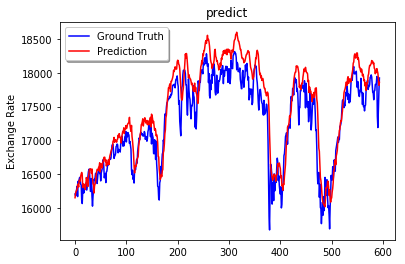

RMSE:311.60794701438215  ,MAE:241.18257938183913  ,MAPE:1.3998318021619474 


In [20]:
# 测试数据集
RMSE,MAE,MAPE,predict_array,y_test = model_predict(fusion_model,[test_news,Test_X],Test_Y,MMScaler,
              save=r'/home/wells/SIOA/DowJonesPredict/SourceCode/PicSave')

In [21]:
predict_array

array([[16152.405 ],
       [16217.571 ],
       [16246.784 ],
       [16263.174 ],
       [16270.294 ],
       [16348.347 ],
       [16352.654 ],
       [16311.205 ],
       [16409.445 ],
       [16407.49  ],
       [16397.379 ],
       [16470.434 ],
       [16504.668 ],
       [16526.838 ],
       [16493.281 ],
       [16304.25  ],
       [16355.3125],
       [16345.215 ],
       [16315.148 ],
       [16351.671 ],
       [16276.268 ],
       [16339.633 ],
       [16451.559 ],
       [16420.965 ],
       [16378.056 ],
       [16318.855 ],
       [16452.248 ],
       [16502.16  ],
       [16568.059 ],
       [16575.006 ],
       [16581.871 ],
       [16556.357 ],
       [16512.69  ],
       [16578.139 ],
       [16452.742 ],
       [16356.367 ],
       [16351.702 ],
       [16222.209 ],
       [16327.932 ],
       [16353.357 ],
       [16380.163 ],
       [16474.3   ],
       [16534.402 ],
       [16571.818 ],
       [16568.576 ],
       [16556.361 ],
       [16605.828 ],
       [16615

In [22]:
y_test

array([[16207.339844],
       [16180.360352],
       [16197.700195],
       [16273.230469],
       [16321.709961],
       [16169.320312],
       [16395.880859],
       [16360.55957 ],
       [16424.529297],
       [16453.099609],
       [16419.390625],
       [16350.669922],
       [16341.549805],
       [16106.320312],
       [16066.370117],
       [16245.929688],
       [16335.709961],
       [16221.980469],
       [16332.69043 ],
       [16303.280273],
       [16279.200195],
       [16370.709961],
       [16268.669922],
       [16267.769531],
       [16324.219727],
       [16458.050781],
       [16532.800781],
       [16572.359375],
       [16576.019531],
       [16414.150391],
       [16245.160156],
       [16256.370117],
       [16437.240234],
       [16168.870117],
       [16028.290039],
       [16173.490234],
       [16266.230469],
       [16424.140625],
       [16408.919922],
       [16449.380859],
       [16513.730469],
       [16503.390625],
       [16503.259766],
       [163